In [1]:
# Priprema podataka za modeliranje
# ==================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

print("📁 PRIPREMA PODATAKA ZA MODELIRANJE VREMENSKE SERIJE")
print("="*60)

📁 PRIPREMA PODATAKA ZA MODELIRANJE VREMENSKE SERIJE


In [2]:
# 1. UČITAVANJE I OSNOVNE TRANSFORMACIJE
# ======================================

print("1️⃣ Učitavanje podataka...")

# Load and basic transformations
df = (
    pd.read_csv(
        '../data/historical_consumption.csv',
        skipinitialspace=True,
        parse_dates=['Datum'],
        dayfirst=True
    )
    .rename(columns={'potrosnja':'Potrošnja'})
    .sort_values('Datum')
    .set_index('Datum')
)

# Ensure proper datetime index
df.index = pd.to_datetime(df.index)

print(f"✅ Učitano {len(df)} redaka podataka")
print(f"📅 Vremenski raspon: {df.index.min()} do {df.index.max()}")

# Handle missing values
print(f"\n2️⃣ Tretiranje nedostajućih vrijednosti...")
print(f"Nedostaju vrijednosti: {df['Potrošnja'].isna().sum()}")

if df['Potrošnja'].isna().sum() > 0:
    print("Strategija: Forward fill + backward fill")
    df['Potrošnja'] = df['Potrošnja'].fillna(method='ffill').fillna(method='bfill')
else:
    print("✅ Nema nedostajućih vrijednosti")

# Handle negative values (if any)
if (df['Potrošnja'] < 0).sum() > 0:
    print(f"⚠️  Pronađeno {(df['Potrošnja'] < 0).sum()} negativnih vrijednosti")
    df.loc[df['Potrošnja'] < 0, 'Potrošnja'] = 0
    print("✅ Negativne vrijednosti zamijenjene s nulom")

display(df.head())
print(f"\nKonačni broj NaN vrijednosti: {df['Potrošnja'].isna().sum()}")

1️⃣ Učitavanje podataka...
✅ Učitano 31 redaka podataka
📅 Vremenski raspon: 2023-01-01 00:00:00 do 2023-01-31 00:00:00

2️⃣ Tretiranje nedostajućih vrijednosti...
Nedostaju vrijednosti: 0
✅ Nema nedostajućih vrijednosti


,Potrošnja
Datum,
2023-01-01,150
2023-01-02,200
2023-01-03,10
2023-01-04,300
2023-01-05,600



Konačni broj NaN vrijednosti: 0


In [3]:
# 2. KREIRANJE ZNAČAJKI (FEATURE ENGINEERING)
# =============================================

print("3️⃣ Kreiranje vremenskih značajki...")

# Create feature-enhanced dataset
df_features = df.copy()

# Temporal features
df_features['dan_u_tjednu'] = df_features.index.dayofweek
df_features['dan_u_mjesecu'] = df_features.index.day
df_features['mjesec'] = df_features.index.month
df_features['tjedan_u_godini'] = df_features.index.isocalendar().week

# Lag features (useful for ML approaches, not ARIMA)
df_features['potrošnja_lag1'] = df_features['Potrošnja'].shift(1)
df_features['potrošnja_lag7'] = df_features['Potrošnja'].shift(7)

# Rolling features
window_sizes = [3, 7]
for window in window_sizes:
    if len(df_features) > window:
        df_features[f'pomični_prosjek_{window}d'] = df_features['Potrošnja'].rolling(window=window).mean()
        df_features[f'pomična_std_{window}d'] = df_features['Potrošnja'].rolling(window=window).std()

# Binary features
df_features['je_vikend'] = (df_features['dan_u_tjednu'] >= 5).astype(int)

print("✅ Kreiral vrlemenske značajke")
print(f"📊 Ukupno značajki: {len(df_features.columns)}")

display(df_features.head(10))

# Check for new missing values due to lags and rolling windows
print(f"\nNedostaju vrijednosti nakon feature engineering:")
for col in df_features.columns:
    missing = df_features[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(df_features)*100:.1f}%)")

3️⃣ Kreiranje vremenskih značajki...
✅ Kreiral vrlemenske značajke
📊 Ukupno značajki: 12


,Potrošnja,dan_u_tjednu,dan_u_mjesecu,mjesec,tjedan_u_godini,potrošnja_lag1,potrošnja_lag7,pomični_prosjek_3d,pomična_std_3d,pomični_prosjek_7d,pomična_std_7d,je_vikend
Datum,,,,,,,,,,,,
2023-01-01,150,6,1,1,52,NaN,NaN,NaN,NaN,NaN,NaN,1
2023-01-02,200,0,2,1,1,150.0,NaN,NaN,NaN,NaN,NaN,0
2023-01-03,10,1,3,1,1,200.0,NaN,120.000000,98.488578,NaN,NaN,0
2023-01-04,300,2,4,1,1,10.0,NaN,170.000000,147.309199,NaN,NaN,0
2023-01-05,600,3,5,1,1,300.0,NaN,303.333333,295.014124,NaN,NaN,0
2023-01-06,20,4,6,1,1,600.0,NaN,306.666667,290.057466,NaN,NaN,0
2023-01-07,0,5,7,1,1,20.0,NaN,206.666667,340.783411,182.857143,215.616503,1
2023-01-08,275,6,8,1,1,0.0,150.0,98.333333,153.324275,200.714286,217.608758,1
2023-01-09,220,0,9,1,2,275.0,200.0,165.000000,145.516322,203.571429,217.729080,0



Nedostaju vrijednosti nakon feature engineering:
  potrošnja_lag1: 1 (3.2%)
  potrošnja_lag7: 7 (22.6%)
  pomični_prosjek_3d: 2 (6.5%)
  pomična_std_3d: 2 (6.5%)
  pomični_prosjek_7d: 6 (19.4%)
  pomična_std_7d: 6 (19.4%)


4️⃣ Podjela podataka za vremenske serije...
📊 JEDNOSTAVNA PODJELA (80/20):
  Trening: 24 dana (2023-01-01 00:00:00 do 2023-01-24 00:00:00)
  Test: 7 dana (2023-01-25 00:00:00 do 2023-01-31 00:00:00)

📊 TIMES SERIES CROSS-VALIDATION (3 split-ova):
  Split 1: Train(10) | Test(7)
    Train: 2023-01-01 00:00:00 do 2023-01-10 00:00:00
    Test:  2023-01-11 00:00:00 do 2023-01-17 00:00:00
  Split 2: Train(17) | Test(7)
    Train: 2023-01-01 00:00:00 do 2023-01-17 00:00:00
    Test:  2023-01-18 00:00:00 do 2023-01-24 00:00:00
  Split 3: Train(24) | Test(7)
    Train: 2023-01-01 00:00:00 do 2023-01-24 00:00:00
    Test:  2023-01-25 00:00:00 do 2023-01-31 00:00:00


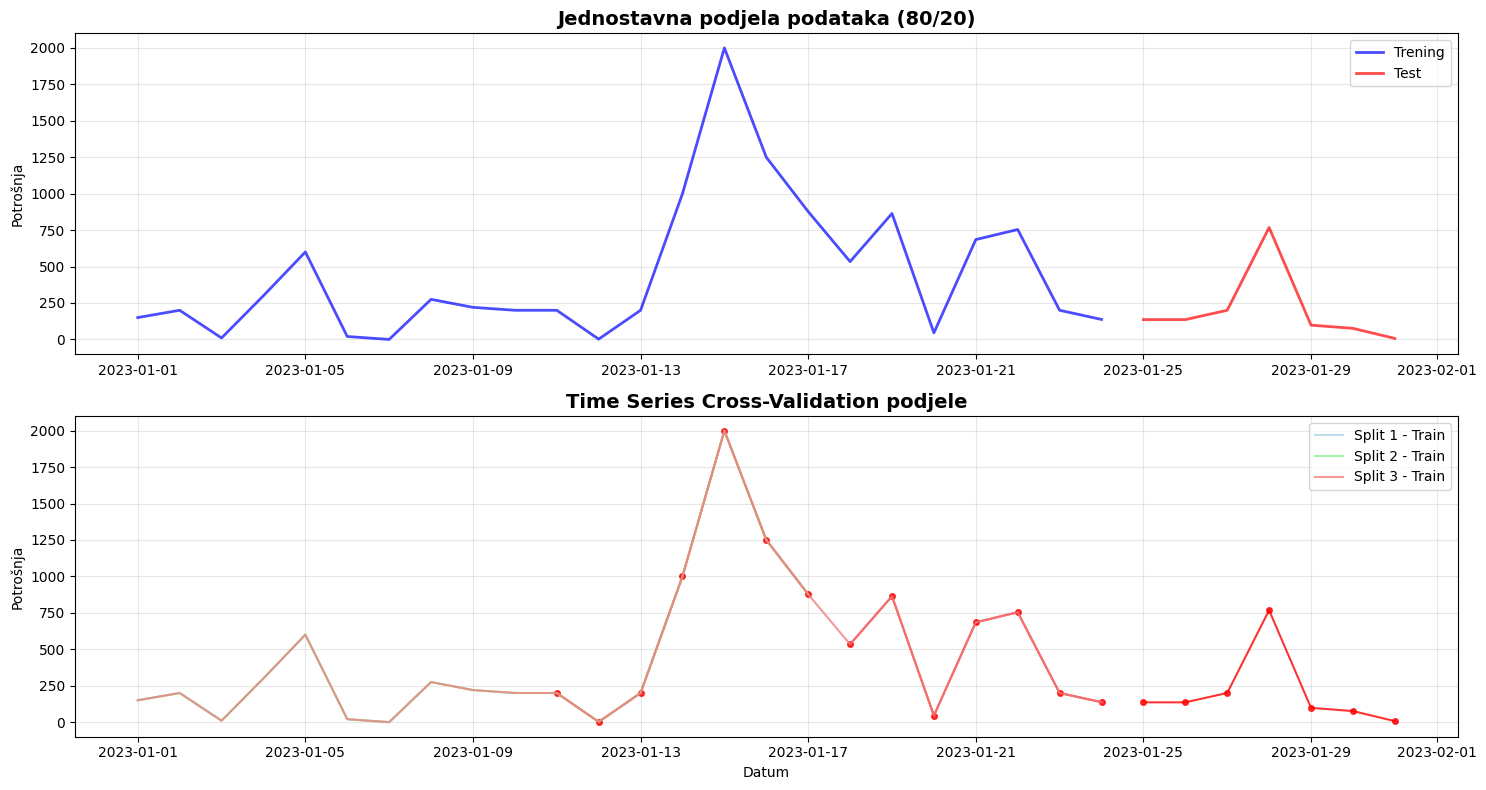


💡 Za ARIMA modeliranje koristit ćemo jednostavnu podelu zbog:
  • ARIMA zahtijeva kontinuitet vremenskih serija
  • Cross-validation je bolji za usporedbu različitih modela
  • Jednostavna podjela je dovoljba za osnovnu evaluaciju


In [4]:
# 3. STRATEGIJA PODJELE PODATAKA
# ==============================

print("4️⃣ Podjela podataka za vremenske serije...")

# For time series, we must respect temporal order
# Option 1: Simple train/test split
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_simple = df.iloc[:split_index].copy()
test_simple = df.iloc[split_index:].copy()

print(f"📊 JEDNOSTAVNA PODJELA (80/20):")
print(f"  Trening: {len(train_simple)} dana ({train_simple.index.min()} do {train_simple.index.max()})")
print(f"  Test: {len(test_simple)} dana ({test_simple.index.min()} do {test_simple.index.max()})")

# Option 2: Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=3)
print(f"\n📊 TIMES SERIES CROSS-VALIDATION (3 split-ova):")

splits_info = []
for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_dates = df.index[train_idx]
    test_dates = df.index[test_idx]
    
    split_info = {
        'split': i+1,
        'train_size': len(train_idx),
        'test_size': len(test_idx),
        'train_start': train_dates.min(),
        'train_end': train_dates.max(),
        'test_start': test_dates.min(),
        'test_end': test_dates.max()
    }
    splits_info.append(split_info)
    
    print(f"  Split {i+1}: Train({len(train_idx)}) | Test({len(test_idx)})")
    print(f"    Train: {train_dates.min()} do {train_dates.max()}")
    print(f"    Test:  {test_dates.min()} do {test_dates.max()}")

# Visualize the splits
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Simple split visualization
axes[0].plot(train_simple.index, train_simple['Potrošnja'], 
             color='blue', alpha=0.7, label='Trening', linewidth=2)
axes[0].plot(test_simple.index, test_simple['Potrošnja'], 
             color='red', alpha=0.7, label='Test', linewidth=2)
axes[0].set_title('Jednostavna podjela podataka (80/20)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Potrošnja')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CV splits visualization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]
    
    axes[1].plot(train_data.index, train_data['Potrošnja'], 
                color=colors[i], alpha=0.8, label=f'Split {i+1} - Train')
    axes[1].plot(test_data.index, test_data['Potrošnja'], 
                color='red', alpha=0.8, marker='o', markersize=4)

axes[1].set_title('Time Series Cross-Validation podjele', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Datum')
axes[1].set_ylabel('Potrošnja')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Za ARIMA modeliranje koristit ćemo jednostavnu podelu zbog:")
print(f"  • ARIMA zahtijeva kontinuitet vremenskih serija")
print(f"  • Cross-validation je bolji za usporedbu različitih modela")
print(f"  • Jednostavna podjela je dovoljba za osnovnu evaluaciju")

In [5]:
# 4. VALIDACIJA PRIPREMNLJENIH PODATAKA
# =====================================

print("5️⃣ Validacija pripremljenih podataka...")

def validate_time_series_data(df, name="Dataset"):
    """Validates time series data quality"""
    
    print(f"\n🔍 VALIDACIJA: {name}")
    print("-" * 50)
    
    # 1. Index validation
    if not isinstance(df.index, pd.DatetimeIndex):
        print("❌ Index nije DatetimeIndex")
        return False
    
    print("✅ Valjan DatetimeIndex")
    
    # 2. Gaps in dates
    if len(df) > 1:
        date_diff = df.index.to_series().diff().dropna()
        expected_freq = date_diff.mode()[0] if len(date_diff) > 0 else pd.Timedelta(days=1)
        
        gaps = date_diff[date_diff != expected_freq]
        if len(gaps) > 0:
            print(f"⚠️  Pronađeno {len(gaps)} prekida u datumima")
            print(f"    Očekivana frekvencija: {expected_freq}")
        else:
            print("✅ Nema prekida u datumima")
    
    # 3. Missing values
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️  {missing_count} nedostajućih vrijednosti")
    else:
        print("✅ Nema nedostajućih vrijednosti")
    
    # 4. Data types
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"📊 {len(numeric_cols)} numeričkih kolona od {len(df.columns)} ukupno")
    
    # 5. Value ranges
    for col in numeric_cols:
        min_val, max_val = df[col].min(), df[col].max()
        if pd.isna(min_val) or pd.isna(max_val):
            continue
        if min_val < 0:
            print(f"⚠️  {col}: negativne vrijednosti (min: {min_val:.2f})")
        if col == 'Potrošnja' and (min_val == max_val):
            print(f"⚠️  {col}: konstante vrijednosti")
    
    print(f"✅ Validacija završena\n")
    return True

# Validate all our datasets
validate_time_series_data(df, "Originalni dataset")
validate_time_series_data(train_simple, "Trening set")
validate_time_series_data(test_simple, "Test set")

# Summary statistics comparison
print("📊 USPOREDBA SKUPOVA PODATAKA:")
print("-" * 50)

comparison_stats = pd.DataFrame({
    'Pun dataset': df['Potrošnja'].describe(),
    'Trening': train_simple['Potrošnja'].describe(),
    'Test': test_simple['Potrošnja'].describe()
})

display(comparison_stats)

# Check for data leakage (future data in training)
if train_simple.index.max() >= test_simple.index.min():
    print("❌ UPOZORENJE: Mogući data leakage - trening sadrži buduće podatke!")
else:
    print("✅ Nema data leakage - temporalni redoslijed je očuvan")

5️⃣ Validacija pripremljenih podataka...

🔍 VALIDACIJA: Originalni dataset
--------------------------------------------------
✅ Valjan DatetimeIndex
✅ Nema prekida u datumima
✅ Nema nedostajućih vrijednosti
📊 1 numeričkih kolona od 1 ukupno
✅ Validacija završena


🔍 VALIDACIJA: Trening set
--------------------------------------------------
✅ Valjan DatetimeIndex
✅ Nema prekida u datumima
✅ Nema nedostajućih vrijednosti
📊 1 numeričkih kolona od 1 ukupno
✅ Validacija završena


🔍 VALIDACIJA: Test set
--------------------------------------------------
✅ Valjan DatetimeIndex
✅ Nema prekida u datumima
✅ Nema nedostajućih vrijednosti
📊 1 numeričkih kolona od 1 ukupno
✅ Validacija završena

📊 USPOREDBA SKUPOVA PODATAKA:
--------------------------------------------------


,Pun dataset,Trening,Test
count,31.000000,24.000000,7.000000
mean,391.741935,446.791667,203.000000
std,452.540088,485.793746,256.184179
min,0.000000,0.000000,7.000000
25%,117.000000,146.750000,87.000000
50%,200.000000,210.000000,136.000000
75%,642.500000,702.250000,168.000000
max,2000.000000,2000.000000,768.000000


✅ Nema data leakage - temporalni redoslijed je očuvan


In [6]:
# 5. EXPORT PRIPREMLJENIH PODATAKA
# ================================

print("6️⃣ Spremanje pripremljenih podataka...")

# Create a clean dataset for modeling
df_for_modeling = df.copy()

# Set proper frequency (important for ARIMA)
df_for_modeling = df_for_modeling.asfreq('D')

# Save datasets
datasets_to_save = {
    'full_dataset.csv': df_for_modeling,
    'train_set.csv': train_simple,
    'test_set.csv': test_simple
}

for filename, dataset in datasets_to_save.items():
    filepath = f'../data/{filename}'
    dataset.to_csv(filepath)
    print(f"✅ Spremljen: {filepath} ({len(dataset)} redaka)")

# Save metadata about preparation
metadata = {
    'preparation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_data_points': len(df),
    'train_size': len(train_simple),
    'test_size': len(test_simple),
    'split_ratio': split_ratio,
    'date_range': f"{df.index.min()} to {df.index.max()}",
    'missing_values_handled': True,
    'frequency_set': 'D',
    'features_created': list(df_features.columns)
}

import json
with open('../data/preparation_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("✅ Metadata spremljena u preparation_metadata.json")

print(f"\n🎯 SAŽETAK PRIPREME:")
print(f"  • Dataset veličine: {len(df)} dana")
print(f"  • Trening/Test podjela: {len(train_simple)}/{len(test_simple)} dana")
print(f"  • Frekvencija postavljena: Dnevno (D)")
print(f"  • Dodatne značajke stvorene: {len(df_features.columns) - 1}")
print(f"  • Podaci spremni za ARIMA modeliranje ✅")

6️⃣ Spremanje pripremljenih podataka...
✅ Spremljen: ../data/full_dataset.csv (31 redaka)
✅ Spremljen: ../data/train_set.csv (24 redaka)
✅ Spremljen: ../data/test_set.csv (7 redaka)
✅ Metadata spremljena u preparation_metadata.json

🎯 SAŽETAK PRIPREME:
  • Dataset veličine: 31 dana
  • Trening/Test podjela: 24/7 dana
  • Frekvencija postavljena: Dnevno (D)
  • Dodatne značajke stvorene: 11
  • Podaci spremni za ARIMA modeliranje ✅


# 📋 SAŽETAK PRIPREME PODATAKA

## Provedeni koraci:

### 1. **Učitavanje i čišćenje**
- ✅ Učitani povijesni podaci o potrošnji
- ✅ Postavljeni DatetimeIndex
- ✅ Obrađene nedostajuće vrijednosti

### 2. **Feature Engineering**
- ✅ Kreiranje vremenskih značajki (dan u tjednu, mjesec, itd.)
- ✅ Lag značajke za ML pristupe
- ✅ Pomične statistike (rolling averages)

### 3. **Podjela podataka**
- ✅ Jednostavna 80/20 podjela za ARIMA
- ✅ Time Series Cross-Validation setup
- ✅ Očuvan temporalni redoslijed

### 4. **Validacija**
- ✅ Provjera kvalitete podataka
- ✅ Validacija vremenskih indeksa
- ✅ Provjera data leakage

### 5. **Export**
- ✅ Spremljeni pripremljeni datasets
- ✅ Metadata za reproducibilnost

## Sljedeći korak:
➡️ **03_Modeling.ipynb** - ARIMA modeliranje i evaluacija